In [42]:
import numpy as np

with open('./kabat_animals.html', 'r') as f:
    data = f.readlines()
    
names = [x.split(', ')[0] for x in data[25:-7]]
sequences = [[x.split(', ')[1].strip(), x.split(',')[2].strip()] for x in data[25:-7]]
animals = [x.split(', ')[3].strip() for x in data[25:-7]]

mask = [1 if len(x[0]) >0 and len(x[1]) >0 else 0 for x in sequences]

names_mask = [x for m, x in zip(mask, names) if m==1]
animals_mask = [x for m, x in zip(mask, animals) if m==1]
sequences_mask = [x for m, x in zip(mask, sequences) if m==1]
seq = [x for x in sequences_mask if len(x[0]) > 100]

seq = [[x[0].replace('-',''), x[1].replace('-', '')] for x in seq]
seq = [[x[0].replace('?',''), x[1].replace('?', '')] for x in seq]

CHARACTERS = "ACDEFGHIKLMNPQRSTVWY"
MAX_LENGTH_VH = 140
MAX_LENGTH_VL = 122

def one_hot_encoder(sequences, max_length):
    encoded = np.zeros((len(sequences), max_length, len(CHARACTERS)), dtype='int')
    
    for i, seq in enumerate(sequences):
        for j, aa in enumerate(seq):
            pos = CHARACTERS.find(aa)
            
            if pos > 0:
                encoded[i, j, pos] = 1
                
    return encoded

VH_sequences = [x[1] for x in seq]
VL_sequences = [x[0] for x in seq]

VH_encoded = one_hot_encoder(VH_sequences, MAX_LENGTH_VH)
VL_encoded = one_hot_encoder(VL_sequences, MAX_LENGTH_VL)

In [43]:
from keras.layers import Input, Embedding, LSTM, Dense, merge, TimeDistributed, RepeatVector, SimpleRNN, GRU, CuDNNGRU, CuDNNLSTM
from keras.models import Model
from keras import backend as K
from keras import layers as L

In [44]:
RNN = CuDNNLSTM

In [45]:
K.clear_session()

In [46]:
VL_input = Input(shape=(MAX_LENGTH_VL,len(CHARACTERS)), dtype='float', name='vl_input')
VH_input = Input(shape=(MAX_LENGTH_VH,len(CHARACTERS)), dtype='float', name='vh_input')

In [47]:
lstm_vl = RNN(32)(VL_input)
lstm_vh = RNN(32)(VH_input)
dense_1_vl = Dense(64, activation='relu')(lstm_vl)
dense_1_vl = L.Dropout(0.3)(dense_1_vl)
# dense_1_vl = L.BatchNormalization()(dense_1_vl)
# dense_1_vl = L.LeakyReLU()(dense_1_vl)

dense_1_vh = Dense(64, activation='relu')(lstm_vh)
dense_1_vh = L.Dropout(0.3)(dense_1_vh)
# dense_1_vh = L.BatchNormalization()(dense_1_vh)
# dense_1_vh = L.LeakyReLU()(dense_1_vh)

In [48]:
merge_layer = merge([dense_1_vl, dense_1_vh], mode='sum')
merge_layer = L.Dropout(0.4)(merge_layer)
# merge_layer = L.BatchNormalization()(merge_layer)
# merge_layer = L.LeakyReLU()(merge_layer)

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/home/gil/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [49]:
dense_1 = Dense(32, activation='relu')(merge_layer)
dense_1 = L.Dropout(0.2)(dense_1)
# dense_1 = L.BatchNormalization()(dense_1)
# dense_1 = L.LeakyReLU()(dense_1)
bottleneck = Dense(10)(dense_1)

In [50]:
Model([VL_input, VH_input], bottleneck).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vl_input (InputLayer)           (None, 122, 20)      0                                            
__________________________________________________________________________________________________
vh_input (InputLayer)           (None, 140, 20)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 32)           6912        vl_input[0][0]                   
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 32)           6912        vh_input[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [51]:
from keras import layers as L

In [52]:
def decoder(sequence_length, name, dense_r_2):
    
    
    repeat_vector_r_1 = RepeatVector(sequence_length)(dense_r_2)

#     dense_r_1_vl = TimeDistributed(Dense(sequence_length))(repeat_vector_r_1)
#     dense_r_1_vl = TimeDistributed(Dense(sequence_length))(repeat_vector_r_1)
    # dense_r_1_vh = TimeDistributed(Dense(MAX_LENGTH_VH))(repeat_vector_r_1[16:])

    lstm_r = RNN(32, return_sequences=True)(repeat_vector_r_1)
    # lstm_r_vh = LSTM(32, return_sequences=True)(dense_r_1_vh)

#     dense_r = Dense(len(CHARACTERS), activation='softmax')(lstm_r)
#     output_r = LSTM(len(CHARACTERS), name=name, return_sequences=True)(lstm_r)
    # dense_r_vl = Dense(len(CHARACTERS), activation='softmax')(lambda_r_vl)
    output_r = Dense(len(CHARACTERS), activation='softmax', name=name)(lstm_r)
    return output_r

In [53]:
dense_r_1 = Dense(32, activation='relu')(bottleneck)
# dense_r_1 = L.BatchNormalization()(dense_r_1)
# dense_r_1 = L.LeakyReLU()(dense_r_1)

dense_r_2 = Dense(64, activation='relu')(bottleneck)
# dense_r_2 = L.BatchNormalization()(dense_r_2)
# dense_r_2 = L.LeakyReLU()(dense_r_2)

dense_r_3 = Dense(64, activation='relu')(dense_r_2)
# dense_r_2 = L.Dropout(0.3)(dense_r_2)
# dense_r_3 = L.BatchNormalization()(dense_r_3)
# dense_r_3 = L.LeakyReLU()(dense_r_3)

In [54]:
decoder_vl = decoder(MAX_LENGTH_VL, 'VL', dense_r_3)
decoder_vh = decoder(MAX_LENGTH_VH, 'VH', dense_r_3)

In [55]:
autoencoder = Model(inputs=[VH_input, VL_input], outputs=[decoder_vh, decoder_vl])

In [56]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vl_input (InputLayer)           (None, 122, 20)      0                                            
__________________________________________________________________________________________________
vh_input (InputLayer)           (None, 140, 20)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 32)           6912        vl_input[0][0]                   
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 32)           6912        vh_input[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [57]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

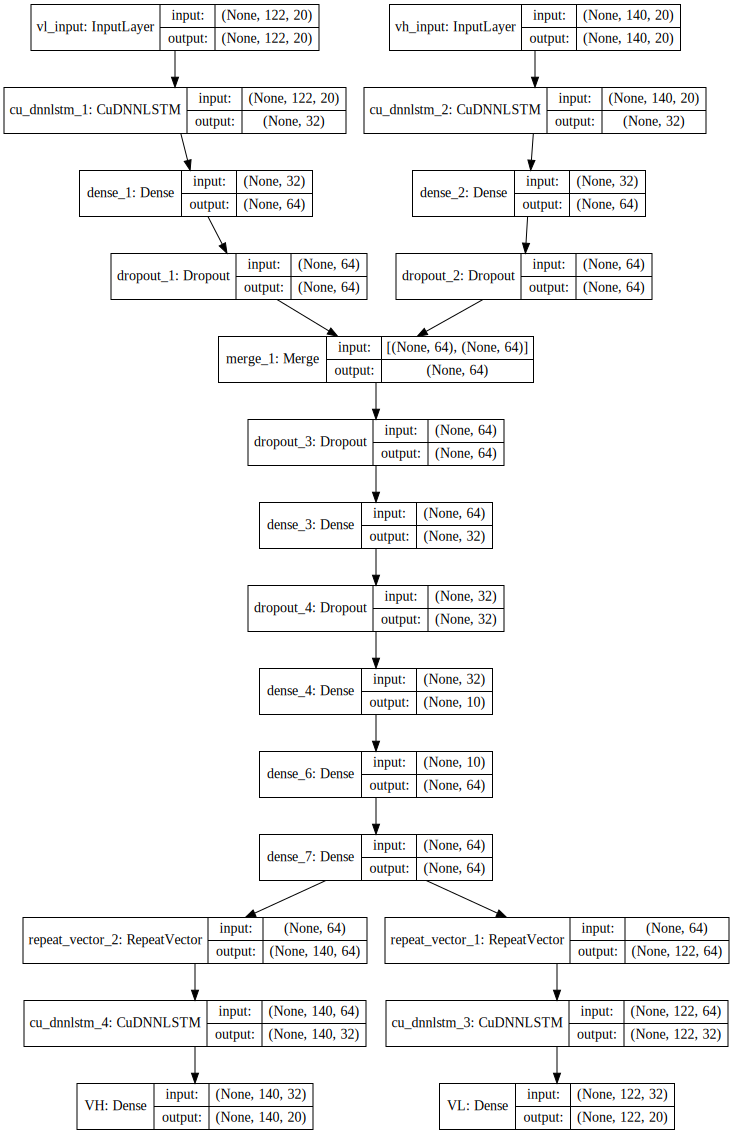

In [58]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [59]:
import keras

In [60]:
def get_loss(mask_value):
    
    mask_value = K.variable(mask_value)
    
    def masked_categorical_crossentropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character '#'
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())

        # multiply categorical_crossentropy with the mask
        loss = K.categorical_crossentropy(y_true, y_pred) * mask

        # take average w.r.t. the number of unmasked entries
        return K.sum(loss) / K.sum(mask)
    
    return masked_categorical_crossentropy

masked_categorical_crossentropy = get_loss(np.zeros(len(CHARACTERS)))

def accuracy(y_true, y_pred):
    mask = K.all(K.equal(y_true, np.zeros(len(CHARACTERS), dtype='int')), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())
    return K.sum((K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), 'float32'), 
                                        K.cast(K.argmax(y_pred, axis=-1), 'float32')), 
                                'float32') * mask)) / K.sum(mask)

In [61]:
# increase b2 value to compensate for sparsity
# does this decrease flactuation in validation set?

autoencoder.compile(keras.optimizers.Adamax(lr=0.002, beta_2 = 0.9999), loss=masked_categorical_crossentropy, metrics=[accuracy])

In [62]:
history = autoencoder.fit([VH_encoded, VL_encoded], [VH_encoded, VL_encoded], epochs=200, 
                          batch_size=32, validation_split=0.2,
                          callbacks=[keras.callbacks.ModelCheckpoint('./bestAutoencoderVHVLLSTM.hdf5',
                                                                     save_best_only=True)])

Train on 1706 samples, validate on 427 samples
Epoch 1/200
1706/1706 [==============================] - 3s 1ms/step - loss: 5.6666 - VH_loss: 2.8417 - VL_loss: 2.8249 - VH_accuracy: 0.1241 - VL_accuracy: 0.1579 - val_loss: 5.5496 - val_VH_loss: 2.7801 - val_VL_loss: 2.7694 - val_VH_accuracy: 0.1394 - val_VL_accuracy: 0.1537
Epoch 2/200
1706/1706 [==============================] - 1s 794us/step - loss: 5.5056 - VH_loss: 2.7628 - VL_loss: 2.7428 - VH_accuracy: 0.1408 - VL_accuracy: 0.1603 - val_loss: 5.5000 - val_VH_loss: 2.7445 - val_VL_loss: 2.7554 - val_VH_accuracy: 0.1469 - val_VL_accuracy: 0.1539
Epoch 3/200
1706/1706 [==============================] - 1s 794us/step - loss: 5.4567 - VH_loss: 2.7300 - VL_loss: 2.7266 - VH_accuracy: 0.1489 - VL_accuracy: 0.1623 - val_loss: 5.4540 - val_VH_loss: 2.7187 - val_VL_loss: 2.7353 - val_VH_accuracy: 0.1518 - val_VL_accuracy: 0.1585
Epoch 4/200
1706/1706 [==============================] - 1s 785us/step - loss: 5.4104 - VH_loss: 2.7074 - VL_los

Epoch 30/200
1706/1706 [==============================] - 1s 783us/step - loss: 4.7324 - VH_loss: 2.3438 - VL_loss: 2.3886 - VH_accuracy: 0.2316 - VL_accuracy: 0.2550 - val_loss: 4.7234 - val_VH_loss: 2.3141 - val_VL_loss: 2.4093 - val_VH_accuracy: 0.2390 - val_VL_accuracy: 0.2529
Epoch 31/200
1706/1706 [==============================] - 1s 798us/step - loss: 4.7085 - VH_loss: 2.3396 - VL_loss: 2.3689 - VH_accuracy: 0.2327 - VL_accuracy: 0.2545 - val_loss: 4.6771 - val_VH_loss: 2.2978 - val_VL_loss: 2.3793 - val_VH_accuracy: 0.2444 - val_VL_accuracy: 0.2597
Epoch 32/200
1706/1706 [==============================] - 1s 773us/step - loss: 4.6866 - VH_loss: 2.3386 - VL_loss: 2.3480 - VH_accuracy: 0.2300 - VL_accuracy: 0.2579 - val_loss: 4.6618 - val_VH_loss: 2.2991 - val_VL_loss: 2.3627 - val_VH_accuracy: 0.2444 - val_VL_accuracy: 0.2591
Epoch 33/200
1706/1706 [==============================] - 1s 784us/step - loss: 4.6680 - VH_loss: 2.3316 - VL_loss: 2.3363 - VH_accuracy: 0.2301 - VL_accu

1706/1706 [==============================] - 1s 798us/step - loss: 4.4316 - VH_loss: 2.2470 - VL_loss: 2.1846 - VH_accuracy: 0.2504 - VL_accuracy: 0.2905 - val_loss: 4.3638 - val_VH_loss: 2.2041 - val_VL_loss: 2.1596 - val_VH_accuracy: 0.2608 - val_VL_accuracy: 0.2980
Epoch 60/200
1706/1706 [==============================] - 1s 783us/step - loss: 4.4120 - VH_loss: 2.2442 - VL_loss: 2.1678 - VH_accuracy: 0.2505 - VL_accuracy: 0.2944 - val_loss: 4.3731 - val_VH_loss: 2.2074 - val_VL_loss: 2.1657 - val_VH_accuracy: 0.2651 - val_VL_accuracy: 0.2947
Epoch 61/200
1706/1706 [==============================] - 1s 810us/step - loss: 4.4035 - VH_loss: 2.2397 - VL_loss: 2.1638 - VH_accuracy: 0.2528 - VL_accuracy: 0.2954 - val_loss: 4.3467 - val_VH_loss: 2.1956 - val_VL_loss: 2.1511 - val_VH_accuracy: 0.2620 - val_VL_accuracy: 0.3031
Epoch 62/200
1706/1706 [==============================] - 1s 820us/step - loss: 4.4044 - VH_loss: 2.2474 - VL_loss: 2.1570 - VH_accuracy: 0.2492 - VL_accuracy: 0.2966 

1706/1706 [==============================] - 1s 783us/step - loss: 4.2653 - VH_loss: 2.1982 - VL_loss: 2.0671 - VH_accuracy: 0.2794 - VL_accuracy: 0.3269 - val_loss: 4.1795 - val_VH_loss: 2.1444 - val_VL_loss: 2.0351 - val_VH_accuracy: 0.2949 - val_VL_accuracy: 0.3417
Epoch 89/200
1706/1706 [==============================] - 1s 774us/step - loss: 4.2513 - VH_loss: 2.1929 - VL_loss: 2.0584 - VH_accuracy: 0.2829 - VL_accuracy: 0.3282 - val_loss: 4.2004 - val_VH_loss: 2.1659 - val_VL_loss: 2.0344 - val_VH_accuracy: 0.2870 - val_VL_accuracy: 0.3341
Epoch 90/200
1706/1706 [==============================] - 1s 790us/step - loss: 4.2434 - VH_loss: 2.1876 - VL_loss: 2.0558 - VH_accuracy: 0.2832 - VL_accuracy: 0.3295 - val_loss: 4.1863 - val_VH_loss: 2.1583 - val_VL_loss: 2.0280 - val_VH_accuracy: 0.2825 - val_VL_accuracy: 0.3416
Epoch 91/200
1706/1706 [==============================] - 1s 781us/step - loss: 4.2420 - VH_loss: 2.1864 - VL_loss: 2.0556 - VH_accuracy: 0.2850 - VL_accuracy: 0.3314 

1706/1706 [==============================] - 1s 785us/step - loss: 4.1303 - VH_loss: 2.1468 - VL_loss: 1.9836 - VH_accuracy: 0.3021 - VL_accuracy: 0.3576 - val_loss: 4.0959 - val_VH_loss: 2.1167 - val_VL_loss: 1.9792 - val_VH_accuracy: 0.3113 - val_VL_accuracy: 0.3648
Epoch 118/200
1706/1706 [==============================] - 1s 774us/step - loss: 4.1335 - VH_loss: 2.1457 - VL_loss: 1.9878 - VH_accuracy: 0.3013 - VL_accuracy: 0.3552 - val_loss: 4.0593 - val_VH_loss: 2.1011 - val_VL_loss: 1.9581 - val_VH_accuracy: 0.3117 - val_VL_accuracy: 0.3719
Epoch 119/200
1706/1706 [==============================] - 1s 782us/step - loss: 4.1300 - VH_loss: 2.1488 - VL_loss: 1.9812 - VH_accuracy: 0.3029 - VL_accuracy: 0.3610 - val_loss: 4.0497 - val_VH_loss: 2.1022 - val_VL_loss: 1.9475 - val_VH_accuracy: 0.3145 - val_VL_accuracy: 0.3799
Epoch 120/200
1706/1706 [==============================] - 1s 781us/step - loss: 4.1254 - VH_loss: 2.1525 - VL_loss: 1.9729 - VH_accuracy: 0.2998 - VL_accuracy: 0.36

Epoch 146/200
1706/1706 [==============================] - 1s 849us/step - loss: 4.0335 - VH_loss: 2.1077 - VL_loss: 1.9259 - VH_accuracy: 0.3311 - VL_accuracy: 0.3856 - val_loss: 3.9754 - val_VH_loss: 2.0670 - val_VL_loss: 1.9084 - val_VH_accuracy: 0.3562 - val_VL_accuracy: 0.4076
Epoch 147/200
1706/1706 [==============================] - 1s 853us/step - loss: 4.0271 - VH_loss: 2.1039 - VL_loss: 1.9233 - VH_accuracy: 0.3426 - VL_accuracy: 0.3881 - val_loss: 3.9672 - val_VH_loss: 2.0744 - val_VL_loss: 1.8928 - val_VH_accuracy: 0.3469 - val_VL_accuracy: 0.4130
Epoch 148/200
1706/1706 [==============================] - 1s 858us/step - loss: 4.0266 - VH_loss: 2.1006 - VL_loss: 1.9260 - VH_accuracy: 0.3414 - VL_accuracy: 0.3833 - val_loss: 3.9780 - val_VH_loss: 2.0554 - val_VL_loss: 1.9226 - val_VH_accuracy: 0.3680 - val_VL_accuracy: 0.3827
Epoch 149/200
1706/1706 [==============================] - 1s 835us/step - loss: 4.0373 - VH_loss: 2.1071 - VL_loss: 1.9302 - VH_accuracy: 0.3387 - VL_

Epoch 175/200
1706/1706 [==============================] - 1s 802us/step - loss: 3.9538 - VH_loss: 2.0604 - VL_loss: 1.8934 - VH_accuracy: 0.3578 - VL_accuracy: 0.3979 - val_loss: 3.8976 - val_VH_loss: 2.0478 - val_VL_loss: 1.8497 - val_VH_accuracy: 0.3590 - val_VL_accuracy: 0.4431
Epoch 176/200
1706/1706 [==============================] - 1s 848us/step - loss: 3.9543 - VH_loss: 2.0721 - VL_loss: 1.8822 - VH_accuracy: 0.3518 - VL_accuracy: 0.4078 - val_loss: 3.8844 - val_VH_loss: 2.0224 - val_VL_loss: 1.8619 - val_VH_accuracy: 0.3840 - val_VL_accuracy: 0.4152
Epoch 177/200
1706/1706 [==============================] - 1s 827us/step - loss: 3.9603 - VH_loss: 2.0683 - VL_loss: 1.8919 - VH_accuracy: 0.3542 - VL_accuracy: 0.3974 - val_loss: 3.8781 - val_VH_loss: 2.0179 - val_VL_loss: 1.8602 - val_VH_accuracy: 0.3897 - val_VL_accuracy: 0.4259
Epoch 178/200
1706/1706 [==============================] - 1s 768us/step - loss: 3.9517 - VH_loss: 2.0687 - VL_loss: 1.8830 - VH_accuracy: 0.3542 - VL_

In [63]:
autoencoder.load_weights('./bestAutoencoderVHVLLSTM.hdf5')

In [64]:
pred = autoencoder.predict([VH_encoded, VL_encoded])

In [65]:
pred[1].argmax(-1)[1]

array([ 2,  7, 17,  9, 16, 15, 15, 15, 15, 15, 15, 15, 15,  5, 14, 14, 17,
       16, 16,  1, 15, 15, 15, 15, 15, 15, 15, 15, 18, 18, 18, 13, 13, 13,
        8,  5,  5, 12, 12, 12,  9,  9,  7, 19, 19, 15, 15, 15, 15, 15,  5,
        5,  5, 12, 12, 14, 15, 15, 15, 15,  5,  5,  5, 16, 16, 16, 16, 16,
       16,  7, 15, 15, 15,  3,  3,  3,  2,  2,  4, 19, 19, 19,  1, 13, 13,
       15, 15, 15, 15, 15, 16, 16, 16,  5,  5,  5,  5,  8,  8,  3,  8,  8,
       14, 14, 14,  5,  5,  5,  5, 16, 16, 15, 15, 15,  5,  5,  5,  5,  5,
        5, 16, 16])

In [66]:
VL_encoded[1].argmax(-1)

array([ 0,  9, 16, 13, 12, 15, 15, 17, 15,  0, 11, 12,  5,  5, 16, 17,  8,
        7, 16,  1, 15,  5,  5, 19, 11, 11, 19,  5, 18, 19, 13, 13,  8, 15,
       12,  5, 15,  0,  9, 17, 16, 17,  7, 19,  2, 11, 16, 11, 14, 12, 15,
       11,  7, 12, 15, 14,  4, 15,  5, 15,  8, 15,  5, 15, 16,  0, 16,  9,
       16,  7, 16,  5, 17, 14,  0,  2,  2, 11,  0, 17, 19, 19,  1,  0, 15,
       16,  2, 15, 15, 15, 16,  5,  7,  4,  5,  0,  5, 16, 16,  9, 16, 17,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [67]:
mask_ = [1 if y__.sum() > 0 else 0 for y_, y__ in zip(pred[1][0], VL_encoded[0])]
hits = [1 if y_.argmax(-1) == y__.argmax(-1) and y__.sum() > 0 else 0 for y_, y__ in zip(pred[1][0], VL_encoded[0])]
print(sum(hits) / sum(mask_))

0.3404255319148936


In [68]:
K.eval(accuracy(VL_encoded[0][np.newaxis,:,:], pred[1][0][np.newaxis,:,:]))

0.34042552

In [69]:
def accuracy_each(y_true, y_pred):
    mask = K.all(K.equal(y_true, np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='int')), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())
#     return mask
    return K.sum(K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), 'float32'), 
                                        K.cast(K.argmax(y_pred, axis=-1), 'float32')), 
                                'float32') * mask, axis=-1) / K.sum(mask, axis=-1)

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
encoder = Model([VL_input, VH_input], bottleneck)

In [72]:
code = encoder.predict([VL_encoded, VH_encoded])

In [73]:
from sklearn.preprocessing import LabelEncoder

In [74]:
le = LabelEncoder().fit(animals)
labels = le.transform(animals)

In [75]:
unique_labels = np.unique(labels)

In [76]:
unique_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [77]:
le.classes_

array(['ARMENIAN HAMSTER', 'BOVINE', 'CHICKEN', 'HAMSTER', 'HUMAN',
       'MOUSE', 'OPOSSUM (MONODELPHIS DOMESTICA)', 'RABBIT', 'RAT',
       'RHESUS MACAQUE (MACACA MULATTA)'], dtype='<U31')

In [78]:
autoencoder.history.history.keys()

dict_keys(['val_loss', 'val_VH_loss', 'val_VL_loss', 'val_VH_accuracy', 'val_VL_accuracy', 'loss', 'VH_loss', 'VL_loss', 'VH_accuracy', 'VL_accuracy'])

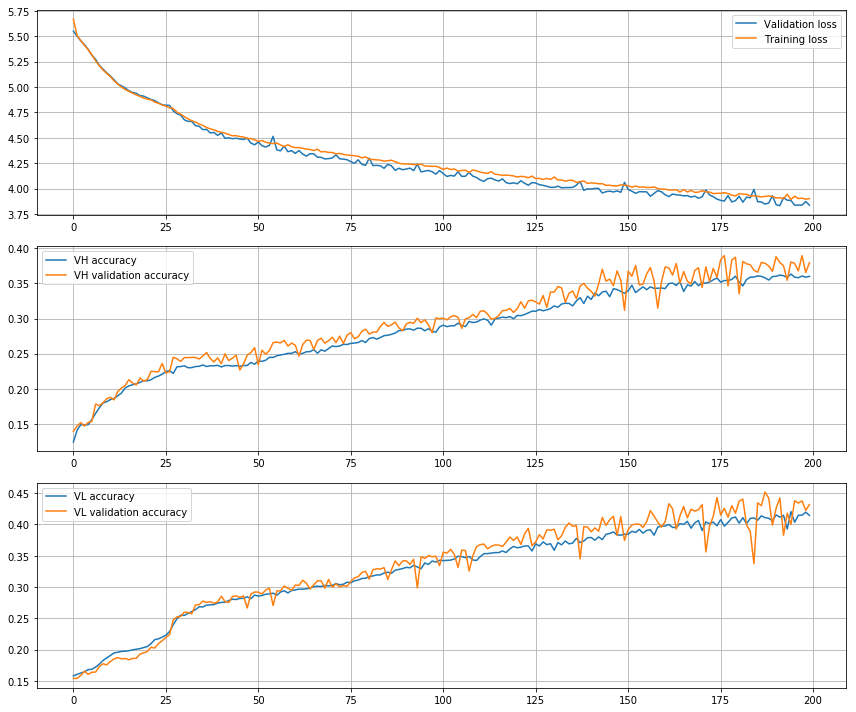

In [79]:
plt.figure(figsize=(12,10))
plt.subplot(311)
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()

plt.subplot(312)
plt.plot(autoencoder.history.history['VH_accuracy'], label='VH accuracy')
plt.plot(autoencoder.history.history['val_VH_accuracy'], label='VH validation accuracy')
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot(autoencoder.history.history['VL_accuracy'], label='VL accuracy')
plt.plot(autoencoder.history.history['val_VL_accuracy'], label='VL validation accuracy')
plt.grid()
plt.legend()
plt.tight_layout()

In [80]:
code.shape

(2133, 10)

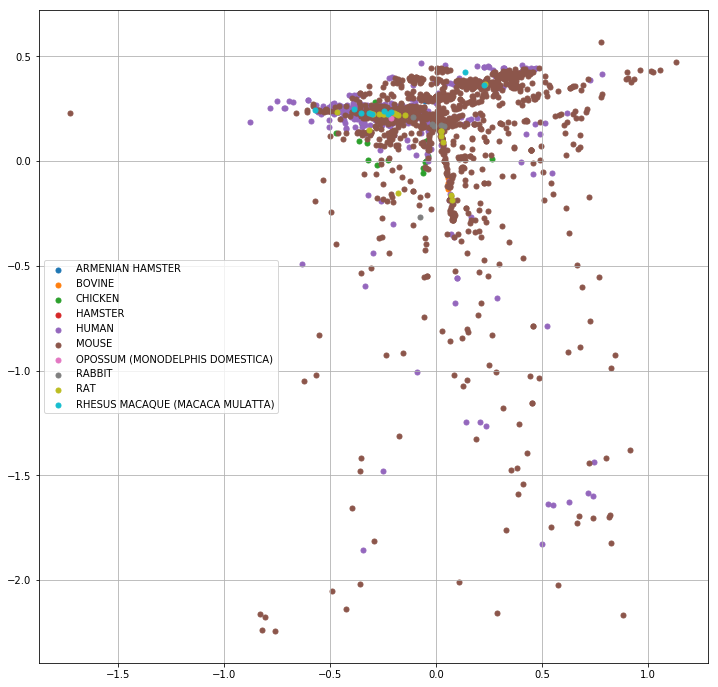

In [81]:
plt.figure(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    plt.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', label=le.classes_[x], s=100)
# plt.ylim([-3,1])
# plt.xlim([-2.5,5])
plt.legend()
plt.grid()

In [41]:
VH_acc = K.eval(accuracy_each(VH_encoded, pred[0]))
VL_acc = K.eval(accuracy_each(VL_encoded, pred[1]))

In [ ]:
VH_acc[VH_acc < 1]

In [ ]:
sns.distplot(VH_acc[VH_acc < 1])

In [ ]:
sns.distplot(VL_acc[VL_acc < 1])